# Анализ данных в задаче кредитного скоринга
Для выполнения этого задания вам понадобятся данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл:

* LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
* SEX: пол клиента (1 = мужской, 2 = женский )
* EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
* MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
* AGE: возраст в годах
* PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. * Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
* BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
* PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
* default - индикатор невозврата денежных средств

## Задание

### 1. Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: 
#### a) Гипотеза о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки 

In [1]:
import pandas as pd
import numpy as np
%config InlineBackend.figure_format='retina'

df_raw = pd.read_csv('data/credit_card_default_analysis.csv',index_col='ID')
df = df_raw.copy()
df.head(3)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,0,0,0,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,0,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0


In [2]:
vernuli = df[df['default'] == 0].loc[:,'LIMIT_BAL']
nevernuli = df[df['default'] == 1].loc[:,'LIMIT_BAL']
print('Медиана кредитного лимита у вернувших кредит:',vernuli.median())
print('Медиана кредитного лимита у невернувших кредит:',nevernuli.median())

Медиана кредитного лимита у вернувших кредит: 150000.0
Медиана кредитного лимита у невернувших кредит: 90000.0


##### Воспользуемся интервальной оценкой разности медиан при помощи бутстрепа

In [3]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return (samples)

a_samples = get_bootstrap_samples(vernuli.values,1000)
b_samples = get_bootstrap_samples(nevernuli.values,1000)

a_samples_med = np.median(a_samples,axis=1)
b_samples_med = np.median(b_samples,axis=1)

In [4]:
# Функция расчета 95% доверительного интервала
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return (boundaries)

print('Доверительный интервал разности медиан:',stat_intervals((a_samples_med - b_samples_med), 0.05))

Доверительный интервал разности медиан: [60000. 70000.]


Разность медиан не содержит 0, т.е. интервалы для медиан лимитов отличаются. Гипотезу о равенстве медиан можно отвергнуть.

#### b) Гипотеза о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?  

In [5]:
# Используем Перестановочный критерий для независимых выборок
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr
    
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

print('p-value:',permutation_test(nevernuli,vernuli,5000))

p-value: 0.0002


p-value мало. Гипотеза о равенстве распределений отвергается.

С практической точки зрения можно сказать, что признак LIMIT_BAL значим.

### 2. Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)  

__а) Решение с помощью доверительного интервала__


   | $X_1$ | $X_2$  
  ------------- | -------------|
  1  | a | b 
  0  | c | d 
  $\sum$ | $n_1$| $n_2$
  
$$ \hat{p}_1 = \frac{a}{n_1}$$

$$ \hat{p}_2 = \frac{b}{n_2}$$


$$\text{Доверительный интервал для }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

In [6]:
vernuli_sex = df[df['default'] == 0]['SEX']-1
nevernuli_sex = df[df['default'] == 1]['SEX']-1

In [7]:
import matplotlib.pyplot as plt
plt.hist(vernuli_sex, label='vernuli')
plt.hist(nevernuli_sex,label='nevernuli')
plt.xlabel('gender')
plt.ylabel('Count')
plt.legend()
plt.show()

<Figure size 640x480 with 1 Axes>

In [8]:
# Доверительный интервал для разности долей независимых выборок
import scipy.stats
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)
print('Доверительный интервал разности долей:',proportions_confint_diff_ind(vernuli_sex, nevernuli_sex))

Доверительный интервал разности долей: (0.03363493274962867, 0.060548077974896725)


В доверительный интервал 0 не входит, следовательно гендерный состав группы людей вернувших и не вернувших кредит отличается. 

__б) Решение с помощью статистического критерия (z-критерий)__

In [9]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized should be 'two-sided', 'less' or 'greater'")
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)
    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

z_stat = proportions_diff_z_stat_ind(vernuli_sex, nevernuli_sex)
p_value=proportions_diff_z_test(z_stat,"two-sided")
print('p_value:', p_value)

p_value: 4.472866521609831e-12


Так как p-value < 0.05, можно отвергнуть гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит одинаков. Среди не вернувших кредит больше мужчин.

### 3. Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборот, не отдаст долг ?  

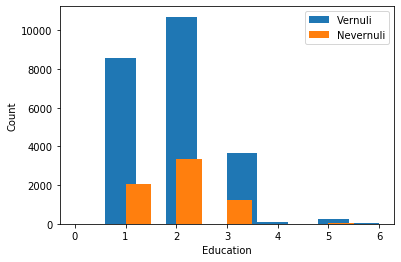

In [10]:
vernuli_ed = df[df['default'] == 0]['EDUCATION']
nevernuli_ed = df[df['default'] == 1]['EDUCATION']

plt.hist(vernuli_ed, label='Vernuli')
plt.hist(nevernuli_ed, label='Nevernuli')
plt.xlabel('Education')
plt.ylabel('Count')
plt.legend()
plt.show()

In [11]:
table_edu = pd.DataFrame(pd.crosstab(df['default'], df['EDUCATION'])).rename(index={0:'Vernuli', 1:'Nevernuli'})
table_edu

EDUCATION,0,1,2,3,4,5,6
default,,,,,,,
Vernuli,14,8549,10700,3680,116,262,43
Nevernuli,0,2036,3330,1237,7,18,8


In [12]:
# Проверка применимости критерия хи-квадрат:количество объектов в таблице сопряженности более 40 и
# доля элементов в таблице < 5 не более 20% 
print('Количество объектов в таблице сопряженности:',table_edu.sum().sum()) # 
print('Доля элементов в таблице < 5:',(table_edu<5).sum().sum()/table_edu.count().sum()) 

Количество объектов в таблице сопряженности: 30000
Доля элементов в таблице < 5: 0.07142857142857142


In [13]:
chi,p,dof,expected=scipy.stats.chi2_contingency(table_edu)
print('p-value:', p)
print('Ожидаемые частоты:', expected)

p-value: 1.2332626245415605e-32
Ожидаемые частоты: [[1.0903200e+01 8.2435980e+03 1.0926564e+04 3.8293596e+03 9.5792400e+01
  2.1806400e+02 3.9718800e+01]
 [3.0968000e+00 2.3414020e+03 3.1034360e+03 1.0876404e+03 2.7207600e+01
  6.1936000e+01 1.1281200e+01]]


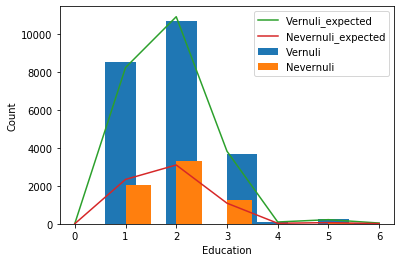

In [14]:
plt.hist(vernuli_ed, label='Vernuli')
plt.hist(nevernuli_ed, label='Nevernuli')
plt.plot([0,1,2,3,4,5,6], expected[0], label='Vernuli_expected')
plt.plot([0,1,2,3,4,5,6], expected[1], label='Nevernuli_expected')
plt.xlabel('Education')
plt.ylabel('Count')
plt.legend()
plt.show()

p-value меньше 0.05, нулевая гипотеза отвергается

In [15]:
# Матрица сопряженности
pd.DataFrame(np.array(pd.crosstab(df['default'], df['EDUCATION'])) - expected).rename(index={0:'Vernuli', 1:'Nevernuli'})

,0,1,2,3,4,5,6
Vernuli,3.0968,305.402,-226.564,-149.3596,20.2076,43.936,3.2812
Nevernuli,-3.0968,-305.402,226.564,149.3596,-20.2076,-43.936,-3.2812


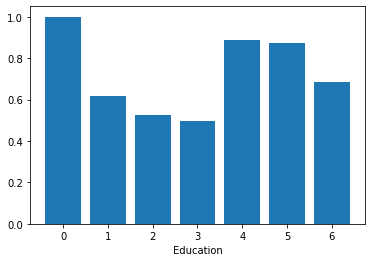

In [16]:
# модифицируем таблицу так, чтобы привести значения ячеек к одному масштабу
diff_edu2_scaled = (table_edu.iloc[0] - table_edu.iloc[1]) / ((table_edu.iloc[0] + table_edu.iloc[1]))
plt.bar(diff_edu2_scaled.index,diff_edu2_scaled)
plt.xlabel('Education')
plt.show()

Образование "Доктор наук" является лучшим индикатором возврата долга, также хорошие показатели у людей с "начальным образованием" и пунктом "другое". Худший индикатор - "выпускник школы"

### 4. Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.  

MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).

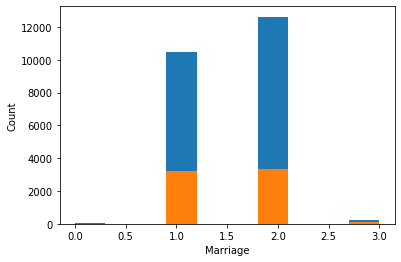

In [17]:
vernuli_mrg = df[df['default'] == 0]['MARRIAGE']
nevernuli_mrg = df[df['default'] == 1]['MARRIAGE']
plt.hist(vernuli_mrg)
plt.hist(nevernuli_mrg)
plt.xlabel('Marriage')
plt.ylabel('Count')
plt.show()

In [18]:
mtrx = pd.DataFrame([vernuli_mrg.value_counts(sort=False),
                nevernuli_mrg.value_counts(sort=False)], index=['vernuli','nevernuli'])
mtrx

,0,1,2,3
vernuli,49,10453,12623,239
nevernuli,5,3206,3341,84


##### Воспользуемся коэффициентом V Крамера для измерения связи между семейным статусом и индикатором дефолта

https://en.wikipedia.org/wiki/Cramér%27s_V  
  
![Image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0168563de020cbca0654cd9cd4265208ee9d3280)

In [19]:
# Проверка применимости критерия хи-квадрат:количество объектов в таблице сопряженности более 40 и
# доля элементов в таблице < 5 не более 20% 
print('Количество объектов в таблицу сопряженности:',mtrx.sum().sum()) # 
print('Доля элементов в таблице < 5:',(mtrx<5).sum().sum()/mtrx.count().sum())

Количество объектов в таблицу сопряженности: 30000
Доля элементов в таблице < 5: 0.0


In [20]:
ts,p,d,e = scipy.stats.chi2_contingency(mtrx)
print('p-value:',p)

p-value: 8.825862457577375e-08


In [21]:
n = mtrx.sum().sum()
r,k = mtrx.shape
print('Коэффициент V Крамера:',np.sqrt((ts/n) / min((k-1), (r-1))))

Коэффициент V Крамера: 0.034478203662766466


Связь между семейным статусом и дефолтом практически отсутствует

### 5. Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: 

##### a) о равенстве медианных значений возрастов людей 

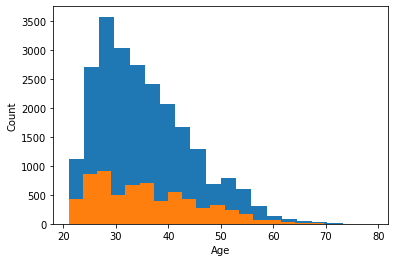

In [22]:
vernuli_age = df[df['default'] == 0]['AGE']
nevernuli_age = df[df['default'] == 1]['AGE']

plt.hist(vernuli_age, bins=20)
plt.hist(nevernuli_age, bins=20)
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [23]:
vern_median_scores = np.median(get_bootstrap_samples(vernuli_age.values, 1000),axis=1)
nevern_median_scores = np.median(get_bootstrap_samples(nevernuli_age.values, 1000),axis=1)

print ("Доверительный интервал медиан для вернувших кредит:",  stat_intervals(vern_median_scores, 0.05))
print ("Доверительный интервал медиан для невернувших кредит:",  stat_intervals(nevern_median_scores, 0.05))
print('Доверительный интервал разности медиан:',
      stat_intervals(vern_median_scores - nevern_median_scores, 0.05))

Доверительный интервал медиан для вернувших кредит: [34. 34.]
Доверительный интервал медиан для невернувших кредит: [34. 35.]
Доверительный интервал разности медиан: [-1.  0.]


##### b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [24]:
# Воспользуемся критерием Манна-Уитни для проверки равенства средних
print('p-value:',scipy.stats.mannwhitneyu(vernuli_age,nevernuli_age).pvalue)

p-value: 0.1862517717449308


Значение p-value не позволяет отклонить нулевую гипотезу. Применим перестановочный критерий

In [25]:
print('p-value:',permutation_test(nevernuli_age,vernuli_age,5000))

p-value: 0.018


p-value позволяет отклонить нулевую гипотезу. Можно сказать, что возраст не является значимым